In [1]:
#importing the os module
import os

#to get the current working directory
%cd /content/drive/MyDrive/OWA
print(os.getcwd())

/content/drive/MyDrive/OWA
/content/drive/MyDrive/OWA


In [2]:
import numpy as np
import tensorflow as tf
import random as rn

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import os
import time
from utils import load_dataset, prep_pixels, summarize_diagnostics, onecycle_scheduler, lr_scheduler, prepare
from models.Minimal import Minimal
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from layers.OWAPooling import OWAPooling
from layers.OWAConv_fm import OWAConv_fm
from layers.OWAPoolingNew import OWAPoolingNew
from numpy.random import seed
from models.vgg13 import VGG13


import tensorflow_datasets as tfds

In [3]:
os.environ['PYTHONHASHSEED'] = '0'

SEED = 1

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(SEED*10)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(SEED*100)

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True,
    as_supervised=True
)

print("Train set size: ", len(train_ds)) # Train set size:  40000
print("Test set size: ", len(test_ds))   # Test set size:  10000
print("Valid set size: ", len(val_ds)) # Valid set size:  10000

# Extract informative features
class_names = metadata.features["label"].names
n_classes = metadata.features["label"].num_classes

print(class_names) # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(n_classes) # 10

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteC14AN3/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteC14AN3/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Train set size:  40000
Test set size:  10000
Valid set size:  10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


# Data preparation and Augmentation

In [5]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

print("Train set size: ", len(train_ds)) # Train set size:  40000
print("Test set size: ", len(test_ds))   # Test set size:  10000
print("Valid set size: ", len(val_ds)) # Valid set size:  10000

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Train set size:  1250
Test set size:  313
Valid set size:  313


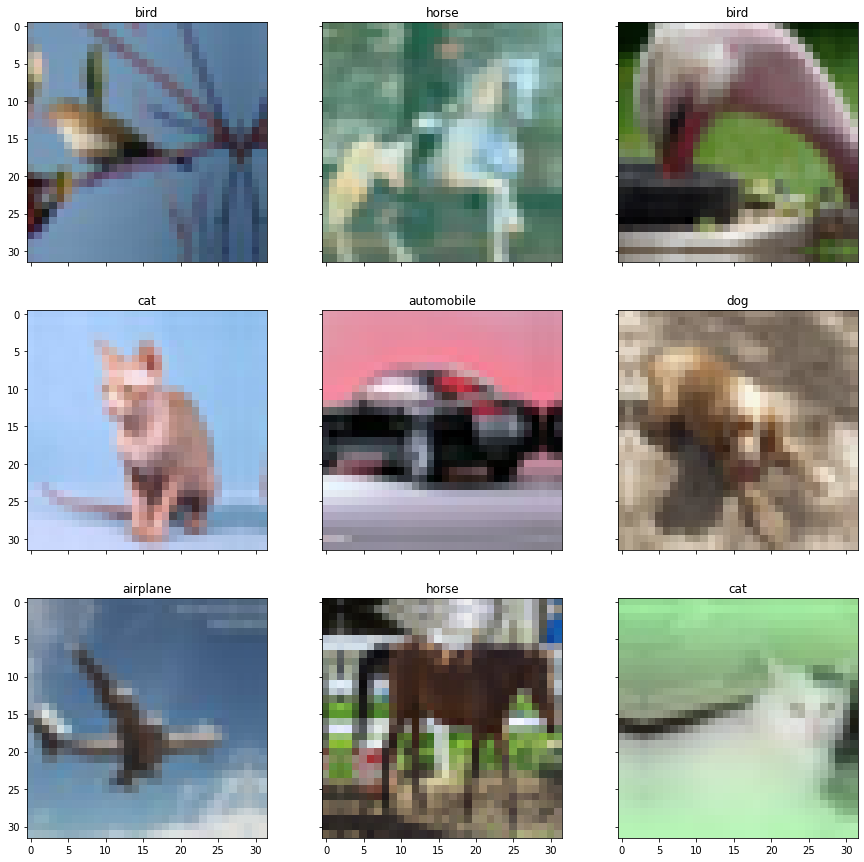

In [6]:
get_label_name = metadata.features['label'].int2str

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in train_ds.take(1):
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j])
            ax[i][j].set_title(get_label_name(labels[i*3+j]))
plt.show()

In [9]:
from keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Activation, Input, Concatenate
from keras.models import Model
from keras.initializers import he_uniform

# define cnn model
def define_model(input_shape = (32, 32, 3), classes=10, owaPool=False, aggregate = False, replace=False, dobrar=True):
    
    if dobrar:
      filters=128
    else:
      filters=64
    
    model = Sequential()
    conv_base = VGG13(classes=classes, input_shape=(32,32,3) )# input: 32x32 images with 3 channels 

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    for i, layer in enumerate(conv_base.layers):   
      if i==0:
        X = layer(X_input)
      elif('block2_conv2' in layer.name and aggregate):
          # Save the input value
          X_shortcut = X
          

          X_shortcut = OWAConv_fm(filters, seed=i)(X_shortcut)
          X_shortcut = Activation('relu')(X_shortcut)

          if replace:
            X = X_shortcut
          else:
            # concatenate X_shortcut with input X
            X = Concatenate(axis=-1)([X, X_shortcut])



          # X = layer(X)
          X = Conv2D(128,kernel_size=[3,3],padding='same', kernel_initializer = he_uniform(seed=i), name='block2_conv2')(X)
          
      elif("pool" in layer.name and X.shape[1] == 16 and owaPool):
        print('Entrou')
        X = OWAPoolingNew(seed=i, all_channels=False)(X)          
      else:
        X = layer(X)

    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [10]:
# define model
model = define_model(classes=n_classes, owaPool=False, aggregate=True, replace=False, dobrar=False)

# initiate SGD optimizer
# sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)
adam = optimizers.Adam()


# For a multi-class classification problem
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer= adam, 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 activation_11 (Activation)     (None, 32, 32, 64)   0           ['block1_conv1[1][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 64)  256         ['activation_11[1][0]']          
 ormalization)                                                                              

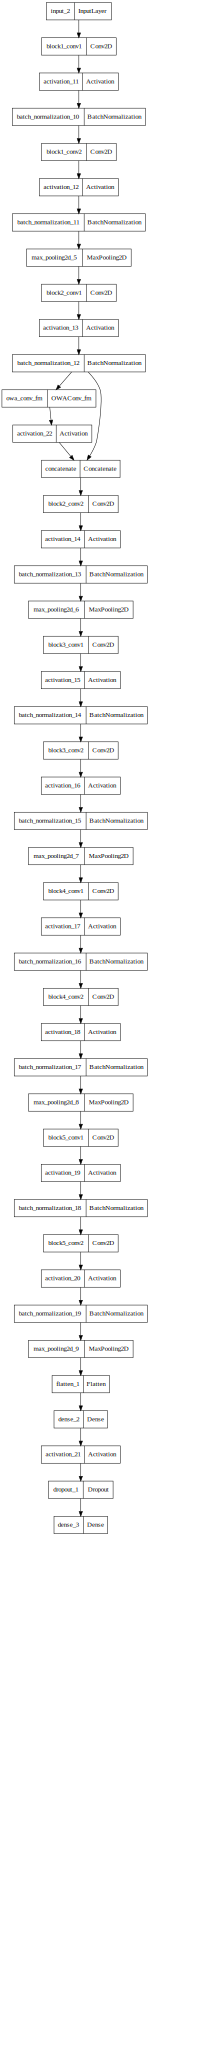

In [11]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
num_epochs = 30
pathaux = 'vgg13_cifar10_aggregate'
checkpoint_filepath = 'experiments/VGG13/CIFAR10/checkpoint/' + pathaux

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


lrr= ReduceLROnPlateau( monitor='val_accuracy',   factor=.5,   patience=3,  min_lr=1e-7) 

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs,
  verbose=1, 
  callbacks=[model_checkpoint_callback, lrr]
)

Epoch 1/30
1250/1250 [==============================] - 165s 123ms/step - loss: 1.7203 - accuracy: 0.3895 - val_loss: 1.2975 - val_accuracy: 0.5262 - lr: 0.0010
Epoch 2/30
1250/1250 [==============================] - 153s 122ms/step - loss: 1.1936 - accuracy: 0.5886 - val_loss: 1.1957 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 3/30
1250/1250 [==============================] - 153s 122ms/step - loss: 0.9764 - accuracy: 0.6769 - val_loss: 0.9820 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 4/30
1250/1250 [==============================] - 152s 122ms/step - loss: 0.8291 - accuracy: 0.7317 - val_loss: 0.8555 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 5/30
1250/1250 [==============================] - 152s 121ms/step - loss: 0.7234 - accuracy: 0.7671 - val_loss: 0.9135 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/30
1250/1250 [==============================] - 153s 122ms/step - loss: 0.6430 - accuracy: 0.7943 - val_loss: 0.7534 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 7/30
1250/1250 [============

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

ValueError: ignored

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.6295 - accuracy: 0.8837
Accuracy 0.8837000131607056


In [ ]:
summarize_diagnostics(history)

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'experiments/VGG13/CIFAR10/history/' + pathaux + '.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
from google.colab import runtime
runtime.unassign()